# Demo app for Conversational image recognition chatbot
Team name - Dragons of the realm

Problem statement ID - SIH1604

Here we present our demo application. The hugging face space may run slow because of the contraints. We need a GPU for fast inderence of our chatty VLM model.

This colab notebook is connected to a T4 GPU runtime. So now it does not take much time to generate outputs. Using this google colab notebook and gradio application is very easy.

Just click on the Run all button from the Runtime menu on the top of your colab notebook.

Probably you have to wait for sometime so that everything gets setup.


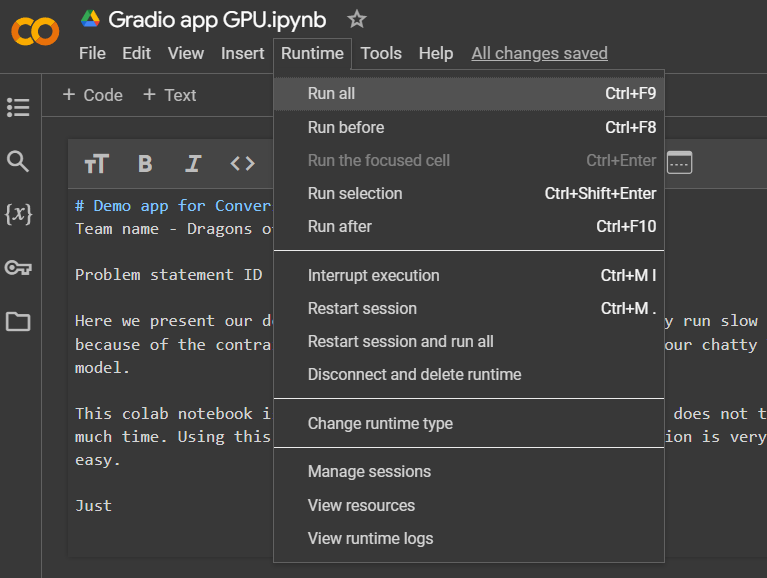



Then you could see a demo application running on the last cell. Use the public url so that you can open the demo application in a new window.

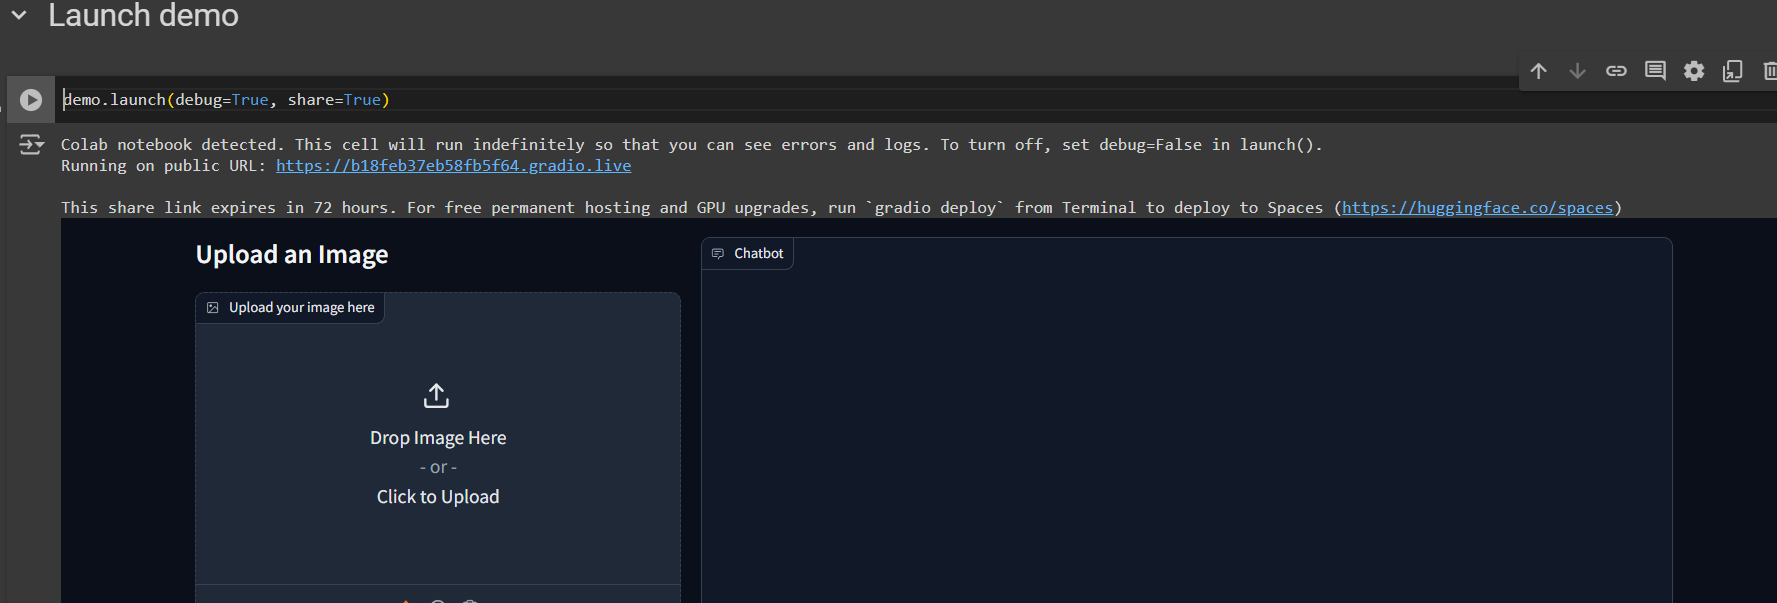

# Import libraries

In [ ]:
%%capture
!pip install gradio
!python -m pip install git+https://github.com/huggingface/transformers

# Object detection

In [ ]:
# import libraries and load the model
%%capture
import random
import requests
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
from transformers import AutoProcessor, Owlv2ForObjectDetection
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

obj_processor = AutoProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")
obj_model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [ ]:
help(AutoProcessor)  # Low-level API


In [ ]:
help(AutoTokenizer)

In [ ]:
help(Owlv2ForObjectDetection)

In [ ]:
from transformers import pipeline

print(pipeline.task_map.keys())  # Shows all available high-level APIs


In [ ]:
%%capture
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 165, 0), (75, 0, 130),
    (255, 255, 0), (0, 255, 255), (255, 105, 180), (138, 43, 226), (0, 128, 0),
    (0, 128, 128), (255, 20, 147), (64, 224, 208), (128, 0, 128), (70, 130, 180),
    (220, 20, 60), (255, 140, 0), (34, 139, 34), (218, 112, 214), (255, 99, 71),
    (47, 79, 79), (186, 85, 211), (240, 230, 140), (169, 169, 169), (199, 21, 133)
]

def detect_objects(image, objects):

    texts = [objects]
    inputs = obj_processor(text=texts, images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = obj_model(**inputs)

    target_sizes = torch.Tensor([image.size[::-1]])
    results = obj_processor.post_process_object_detection(
        outputs=outputs, threshold=0.2, target_sizes=target_sizes
    )

    i = 0
    text = texts[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
    return image, boxes, scores, labels

def annotate_image(image, boxes, scores, labels, objects):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        box = [round(coord, 2) for coord in box.tolist()]
        color = colors[label % len(colors)]
        draw.rectangle(box, outline=color, width=3)
        draw.text((box[0], box[1]), f"{objects[label]}: {score:.2f}", font=font, fill=color)

    return image

# Chatbot

In [ ]:
%%capture
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from PIL import Image
import requests

#cbt_processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")
#cbt_model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", device_map="cuda")

cbt_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype="auto",
    device_map="auto",
)

cbt_processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct"
)

In [ ]:
help(Qwen2VLForConditionalGeneration)

In [ ]:
%%capture
import random
import time
import gradio as gr

global history
history = [
            {
                "role": "system",
                "content" : [
                    {
                        "type": "image",
                    },
                    {
                        "type": "text",
                        "text": "You are an conversation image recognition chatbot. Communicate with humans using natural language. Recognize the images, have a spatial understanding and answer the questions in a concise manner. Generate the best response for a user query. It must be correct lexically and grammatically.",
                    }
                ]
            }
        ]

with gr.Blocks() as demo:

    with gr.Row():

        with gr.Column(scale=1):

                gr.Markdown("## Upload an Image")
                image_input = gr.Image(type="pil", label="Upload your image here")
                objects_input = gr.Textbox(label="Enter the objects to detect (comma-separated)", placeholder="e.g. 'cat, dog, car'")
                image_output = gr.Image(type="pil", label="Detected Objects")

                def run_object_detection(image, objects):
                    object_list = [obj.strip() for obj in objects.split(",")]
                    image, boxes, scores, labels = detect_objects(image, object_list)
                    annotated_image = annotate_image(image, boxes, scores, labels, object_list)
                    history.append({
                        'role': 'system',
                        'content': [
                            {
                                'type': 'text',
                                'text': f'In the image the objects detected are {labels}'
                            }
                        ]
                    })
                    return annotated_image

                detect_button = gr.Button("Detect Objects")
                detect_button.click(fn=run_object_detection, inputs=[image_input, objects_input], outputs=image_output)

        with gr.Column(scale=2):

                chatbot = gr.Chatbot()
                msg = gr.Textbox()
                clear = gr.ClearButton([msg, chatbot])

                def user(message, chat_history):
                    return "", chat_history + [[message, ""]]

                def chat_function(image, chat_history):

                    message = ''

                    if chat_history[-1][0] is not None:
                        message = str(chat_history[-1][0])

                    history.append({
                        "role": "user",
                        "content" : [
                            {
                                "type": "text",
                                "text": message
                            }
                        ]
                    })

                    text_prompt = cbt_processor.apply_chat_template(history, add_generation_prompt=True)

                    inputs = cbt_processor(
                        text = [text_prompt],
                        images = [image],
                        padding = True,
                        return_tensors = "pt"
                    )

                    inputs = inputs.to("cuda")

                    output_ids = cbt_model.generate(**inputs, max_new_tokens=1024)

                    generated_ids = [
                        output_ids[len(input_ids) :]
                        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
                    ]

                    bot_output = cbt_processor.batch_decode(
                        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
                    )

                    history.append({
                        "role": "assistant",
                        "content" : [
                            {
                                "type": "text",
                                "text": bot_output
                            }
                        ]
                    })

                    bot_output_str = str(bot_output).replace('"', '').replace('[', '').replace(']', '').replace("\n", "<br>")

                    chat_history[-1][1] = ""
                    for character in bot_output_str:
                        chat_history[-1][1] += character
                        time.sleep(0.05)
                        yield chat_history

                msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(chat_function, [image_input, chatbot], [chatbot])
                clear.click(lambda :None, None, chatbot, queue=False)

# Launch demo

In [ ]:
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9c2ac569d1178a7d1e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
